In [1]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations
from src.utils.directories import get_parent_directory
from src.models.corr_func import score_metrics

In [2]:
parent_dir = get_parent_directory()
parent_dir

'/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence'

In [3]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = os.path.join(parent_dir, 'data/processed/ml_ready/1906_time.pkl')
arctic_df = pd.read_pickle(arctic_pkl)

In [4]:
global_pkl = os.path.join(parent_dir, "data/processed/Mashayek2022/input_microstructure.pkl")
global_df = pd.read_pickle(global_pkl)
global_df = global_df.rename(columns={'lat': 'latitude', 'log_N2_sort': 'log_N2'})

## With SIC and MLD
700,000 datapoints

#### Filter out where depth is smaller than MLDJ (second derivative of potential density)

In [34]:
# MLDJ generates better results than MLDI, also according to literature and visual inspectation
MLD_df = arctic_df[arctic_df['depth'] >= arctic_df['MLDJ']]

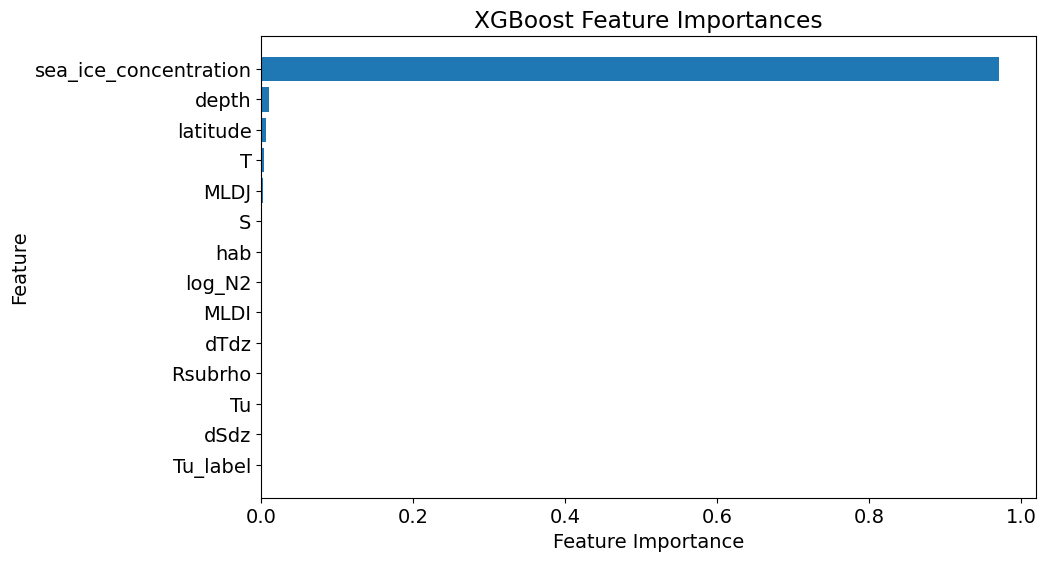

In [35]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC)

In [36]:
filename = os.path.join(parent_dir, "models/XGboost/SIC_XG.sav")
from pickle import dump, load

filename = os.path.join(parent_dir, "models/XGBoost/SIC_xgboostMLD.sav")
dump([xgb_regressor_all_SIC, X_train_SIC, X_test_all_SIC, y_train_SIC,y_test_all_SIC], open(filename, 'wb'))

In [53]:
arctic_df = encode_tulabel(arctic_df)

In [59]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

SIC_all_testdf = create_testdf(X_test_df_SIC, y_test_df_SIC, y_pred_df_SIC)
#plot_residuals(arctic_all_testdf)

merged_df_SIC = SIC_all_testdf.merge(arctic_df, on=xstringlist_all_SIC+ystringlist_all_SIC)
merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstringlist_all_SIC+ystringlist_all_SIC)
residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])

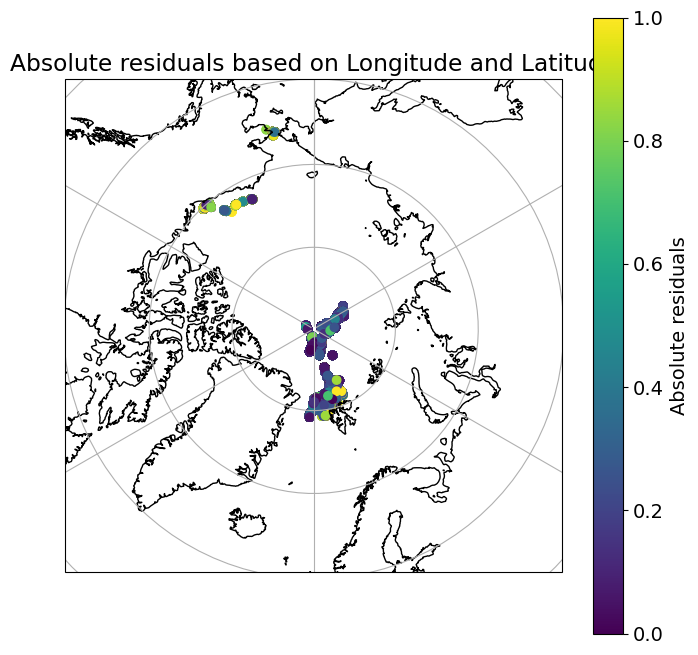

In [61]:
stereo_plot(merged_df_SIC, abs(residuals_SIC), "Absolute residuals")

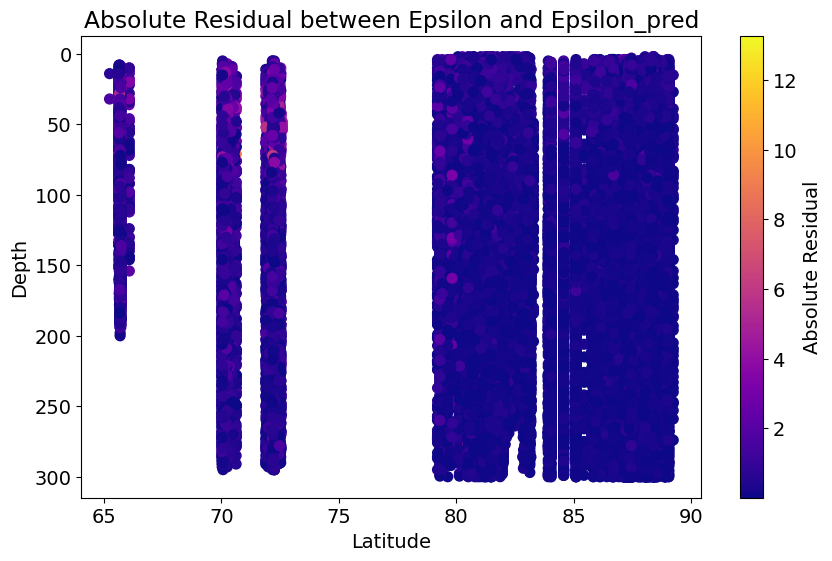

In [11]:
# arctic_all_testdf
plot_residuals(merged_df_SIC)

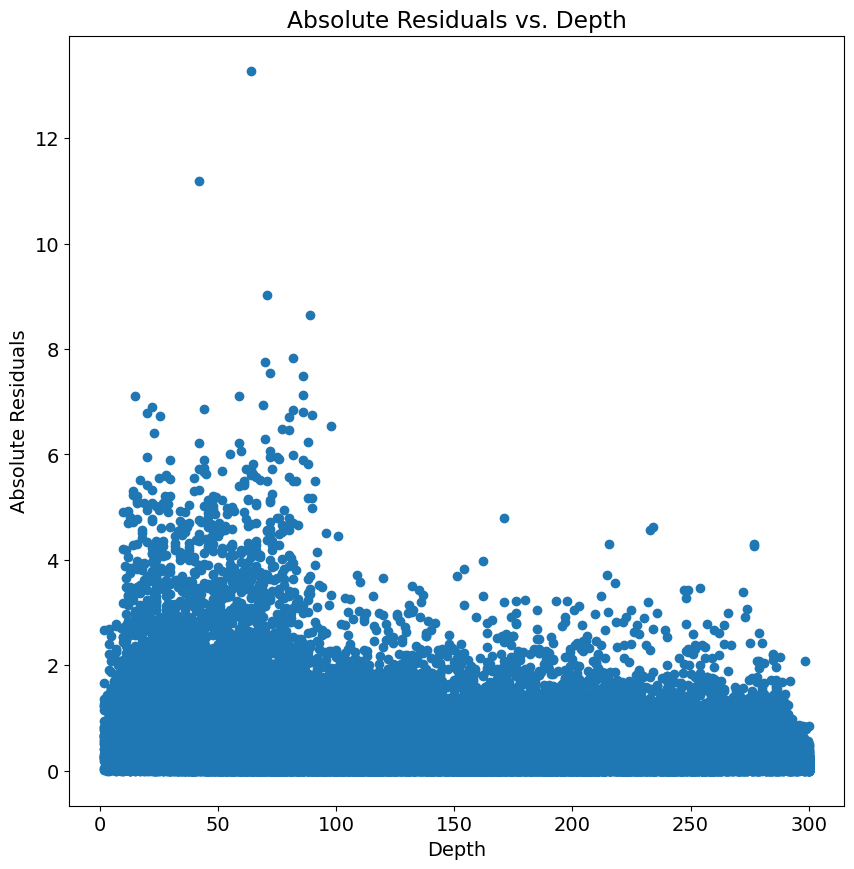

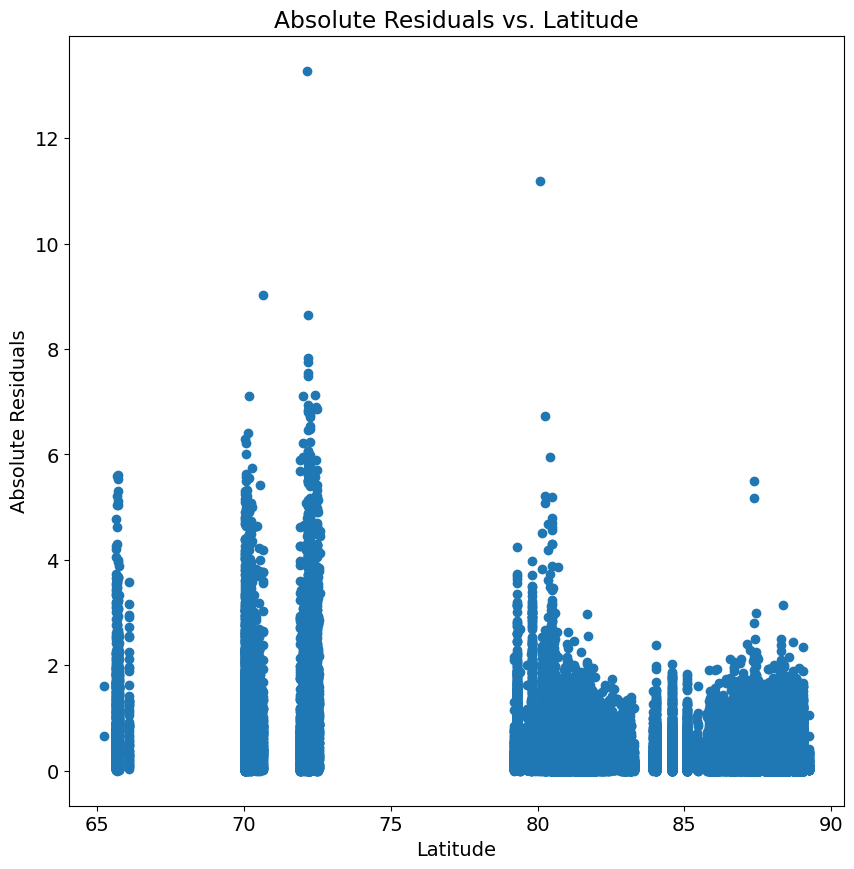

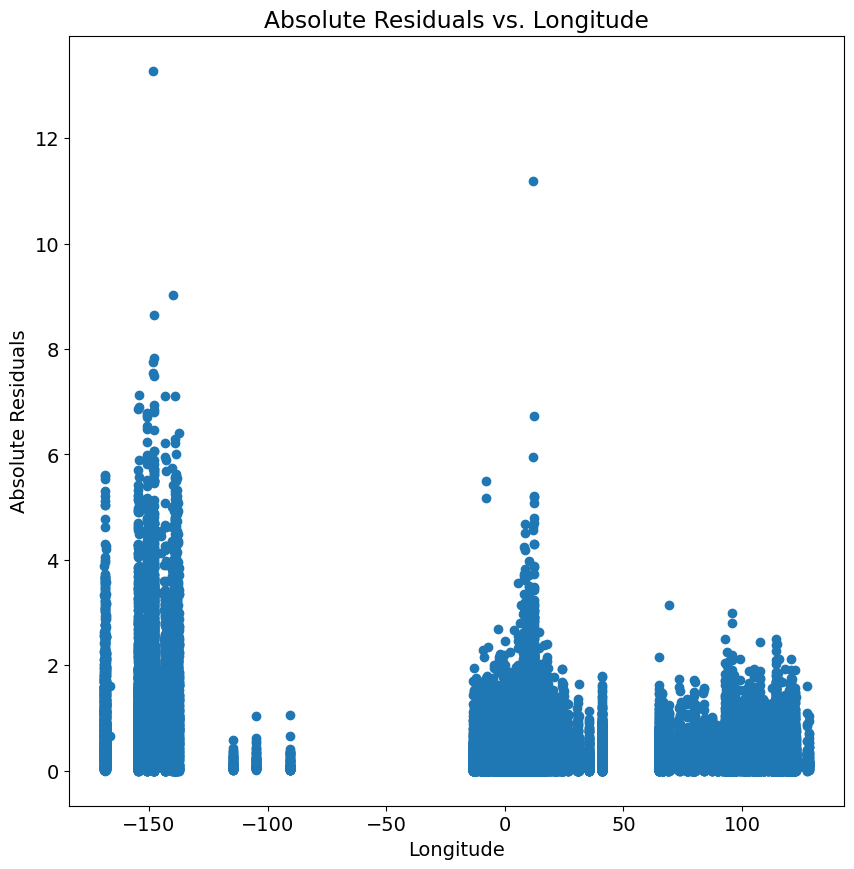

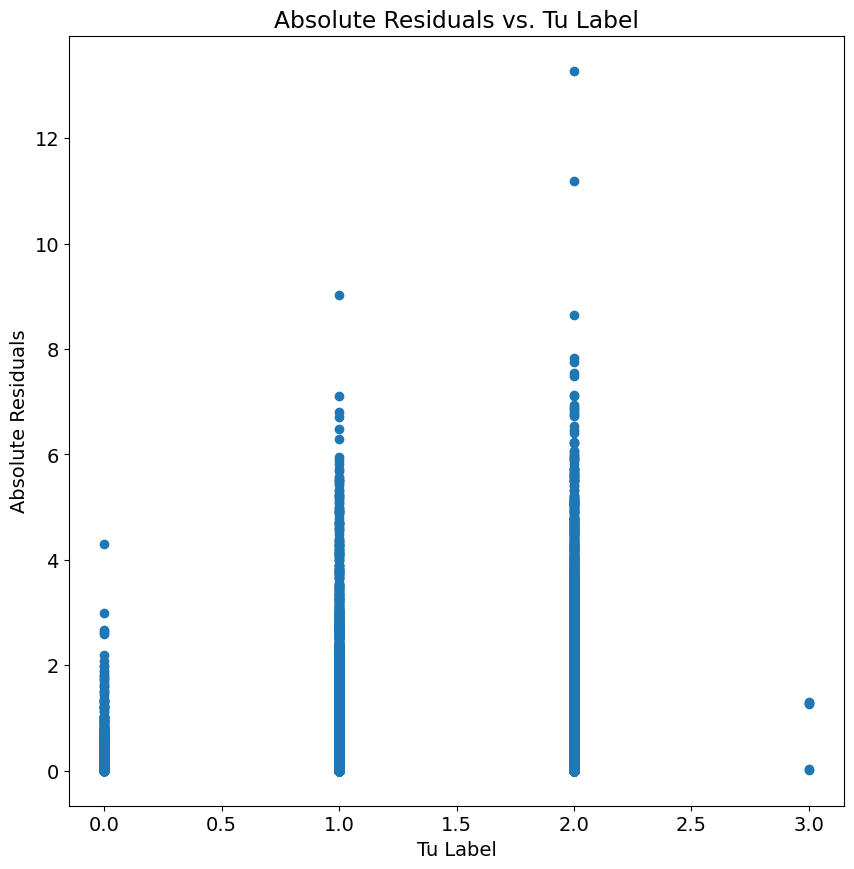

In [12]:
plot_correlations(merged_df_SIC)

## Incl MLD depths

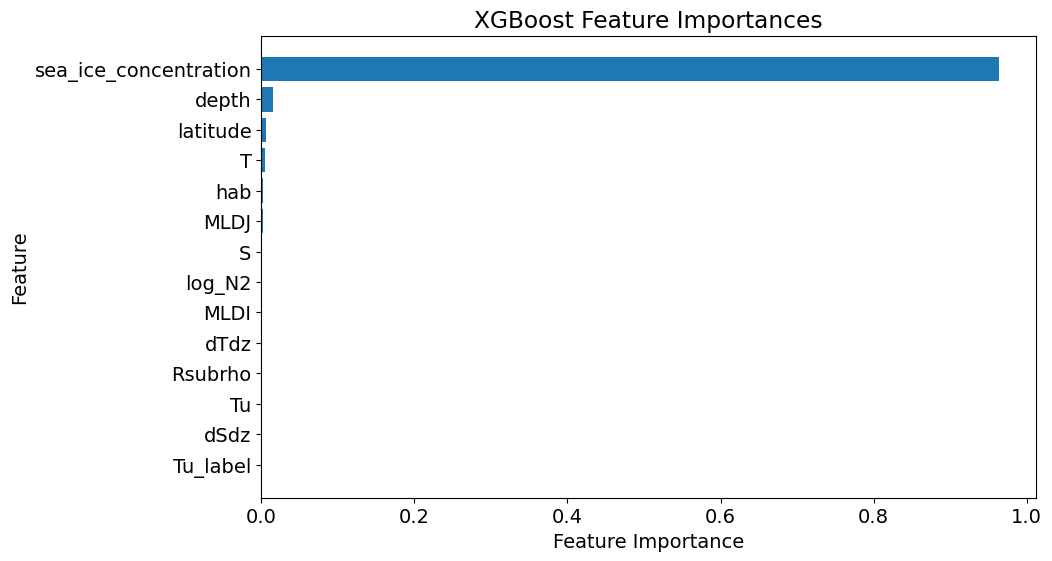

In [23]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(arctic_df, xstringlist_all_SIC, ystringlist_all_SIC)

In [24]:
print(r2_all_SIC)

0.9775364792381736


In [25]:
os.getcwd()
filename = os.path.join(parent_dir, "models/XGboost/SIC_XG_incMLD.sav")

## Vary train and test

In [23]:
import xgboost as xgb
from sklearn.model_selection import learning_curve

def XGBoost_regressor(dataframe, xfeatures, yfeatures, cruise_test=False):
    """Perform Random Forest Regression on the given dataset.

    The function applies random forest regression to predict the target variable specified by yfeatures
    using the features specified by xfeatures.

    Parameters:
    - dataframe (pandas.DataFrame): The input dataset.
    - xfeatures (list): List of column names representing the input features.
    - yfeatures (list): List of column names representing the target variable.

    Returns:
    - pipeline (sklearn.pipeline.Pipeline): The trained pipeline containing the MinMaxScaler and RandomForestRegressor.
    - y_test (pandas.Series): The true values of the target variable for the test dataset.
    - X_test (pandas.DataFrame): The input features of the test dataset.
    - importances (numpy.ndarray): The feature importances calculated by the RandomForestRegressor.
    """
    if "Tu_label" in xfeatures:
        hallo = Tu_label(dataframe.Tu)
        dataframe["Tu_label"] = hallo

        dataframe = encode_tulabel(dataframe)

    if 'log_eps' not in dataframe.columns:
        dataframe['log_eps'] = dataframe['eps'].apply(lambda x: math.log(x))

    # Stop depth at 300m
    # dataframe = dataframe[dataframe["depth"] <= 300]
    
    SEED = 42
    
    if isinstance(cruise_test, str):
        # split test and train dataframe accordingly to test
        train_df = dataframe[dataframe["cruise"] != cruise_test]
        test_df = dataframe[dataframe["cruise"] == cruise_test]
    
        X_train = train_df[xfeatures]
        X_test = test_df[xfeatures]
        y_train = train_df[yfeatures]
        y_test = test_df[yfeatures]
         
    else:
        x = dataframe[xfeatures]
        y = dataframe[yfeatures]

        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)
    
    # Define the XGBoost regressor with hyper parameters from tuning
    xgb_regressor = xgb.XGBRegressor(learning_rate=0.1, n_estimators=300, max_depth=7, random_state=SEED)

    # Fit the regressor on the training data
    xgb_regressor.fit(X_train, y_train)

    # Predict on the test set
    y_pred = xgb_regressor.predict(X_test)

    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)

    # Plot feature importances
    feature_importances = xgb_regressor.feature_importances_
    sorted_indices = feature_importances.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
    plt.yticks(range(len(feature_importances)), [xfeatures[i] for i in sorted_indices])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('XGBoost Feature Importances')
    plt.show()
    
    return xgb_regressor, r2, y_test, y_pred, X_test, feature_importances, X_train, y_train


In [ ]:
 # Plot learning curve
    train_sizes, train_scores, test_scores = learning_curve(xgb_regressor, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training R2')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.plot(train_sizes, test_mean, label='Validation R2')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
    plt.xlabel('Training Set Size')
    plt.ylabel('R2 Score')
    plt.title('XGBoost Learning Curve')
    plt.legend()
    plt.show()

In [19]:
arctic_df.cruise.unique()

array(['NICE-2015', 'ArcticMix', 'Mosaic', 'Haakon Mosby',
       'IPY Barneo 2007', 'IPY Barneo 2008', 'Nansen Legacy 2018',
       'Nansen Legacy 2019', 'ASCOS'], dtype=object)

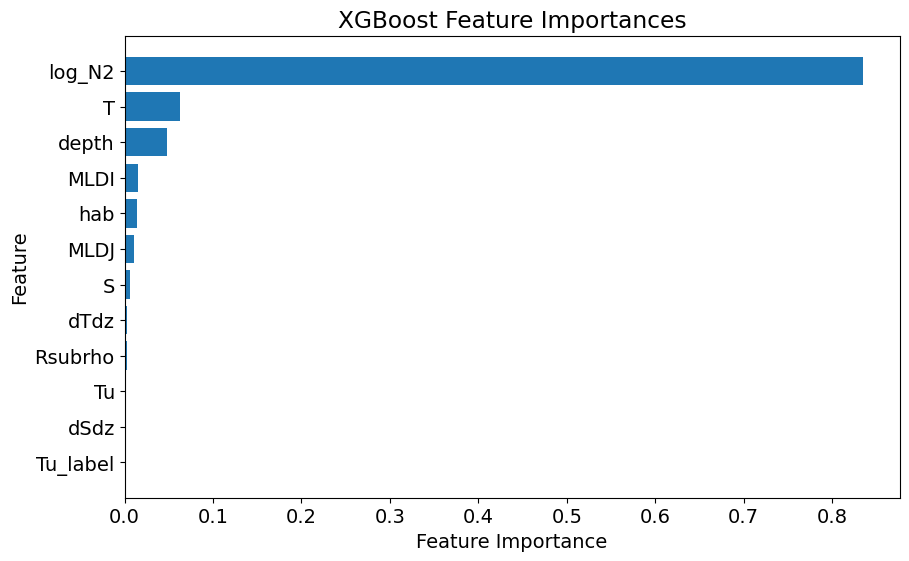

In [61]:
# xstringlist_all_SIC = ['sea_ice_concentration', 'latitude', 'depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'Tu']
# exclude sea_ice_concentration and latitude
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(arctic_df, xstringlist_all_SIC, ystringlist_all_SIC, "Nansen Legacy 2018")

In [64]:
score_metrics(y_test_all_SIC, y_pred_all_SIC)

R2 Score: -29.6347
Mean Error (ME): -1.5554
Mean Absolute Error (MAE): 2.3994
Residual Standard Deviation: 3.6601


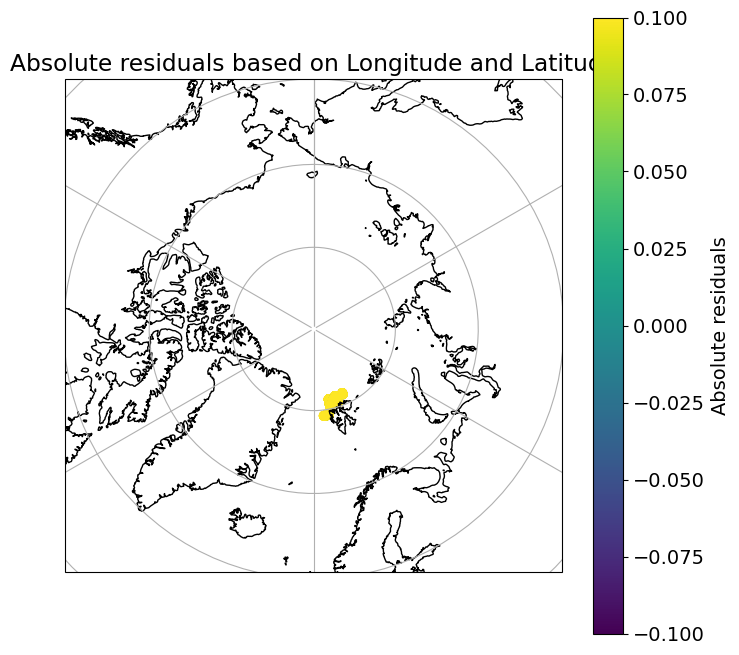

In [63]:
arctic_df = encode_tulabel(arctic_df) # convert into integer

# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

SIC_all_testdf = create_testdf(X_test_df_SIC, y_test_df_SIC, y_pred_df_SIC)

merged_df_SIC = SIC_all_testdf.merge(arctic_df, on=xstringlist_all_SIC+ystringlist_all_SIC)
merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstringlist_all_SIC+ystringlist_all_SIC)
residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])
stereo_plot(merged_df_SIC, abs(residuals_SIC), "Absolute residuals")

## Hyperparameter tuning

In [22]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

def XGBoost_regressor_tuning(dataframe, xfeatures, yfeatures):
    if "Tu_label" in xfeatures:
        hallo = Tu_label(dataframe.Tu)
        dataframe["Tu_label"] = hallo

        dataframe = encode_tulabel(dataframe)

    if 'log_eps' not in dataframe.columns:
        dataframe['log_eps'] = dataframe['eps'].apply(lambda x: math.log(x))

    # Stop depth at 300m
    # dataframe = dataframe[dataframe["depth"] <= 300]

    x = dataframe[xfeatures].values
    y = dataframe[yfeatures].values

    # Split into train and test sets
    SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

    # Define the parameter grid for grid search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001]
    }

    # Define the XGBoost regressor
    xgb_regressor = xgb.XGBRegressor(random_state=SEED)

    # Perform grid search
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predict on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)

    # Plot feature importances
    feature_importances = best_model.feature_importances_
    sorted_indices = feature_importances.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
    plt.yticks(range(len(feature_importances)), [xfeatures[i] for i in sorted_indices])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('XGBoost Feature Importances')
    plt.show()

    return best_model, r2, y_test, y_pred, X_test, feature_importances, best_params


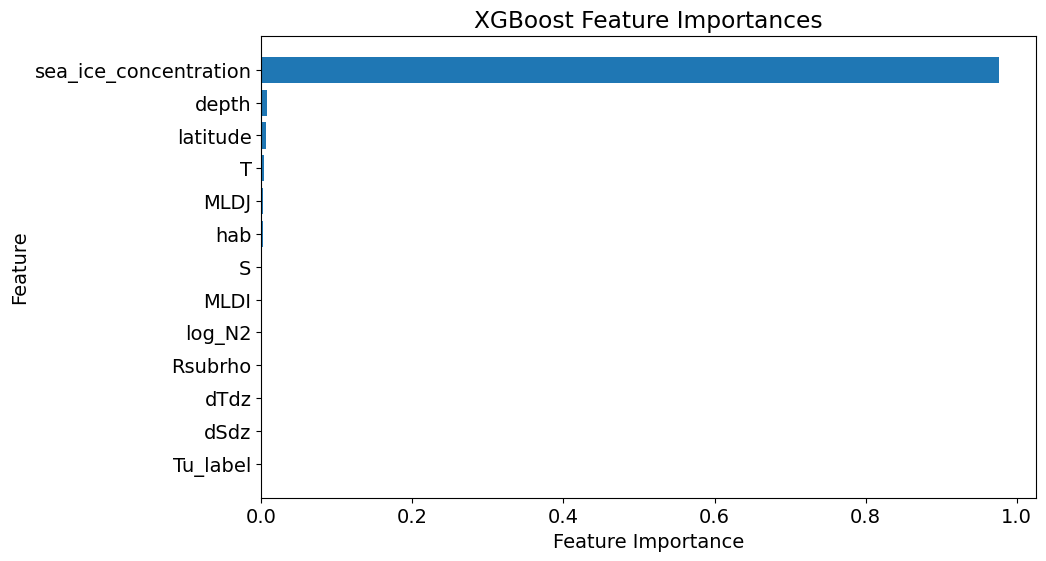

In [24]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

best_model, r2_tune, y_test_tune, y_pred_tune, X_test_tune, feature_importances_tune, best_params  =  XGBoost_regressor_tuning(MLD_df, xstringlist_all_SIC, ystringlist_all_SIC)

In [25]:
best_model_params = best_model.get_params()
print(best_model_params)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [30]:
import joblib

# Save the parameters
joblib.dump(best_model, 'XGboost/best_model.sav')
joblib.dump(r2_tune, 'XGboost/r2_tune.sav')
joblib.dump(y_test_tune, 'XGboost/y_test_tune.sav')
joblib.dump(y_pred_tune, 'XGboost/y_pred_tune.sav')
joblib.dump(X_test_tune, 'XGboost/X_test_tune.sav')
joblib.dump(feature_importances_tune, 'XGboost/feature_importances_tune.sav')
joblib.dump(best_params, 'XGboost/best_params.sav')

['XGboost/best_params.sav']

best_model = joblib.load('best_model.sav')
r2_tune = joblib.load('r2_tune.sav')
y_test_tune = joblib.load('y_test_tune.sav')
y_pred_tune = joblib.load('y_pred_tune.sav')
X_test_tune = joblib.load('X_test_tune.sav')
feature_importances_tune = joblib.load('feature_importances_tune.sav')
best_params = joblib.load('best_params.sav')

In [ ]:
filename = "SIC_xgboost.sav"

dump([xgb_regressor_all_SIC, X_train_SIC, X_test_all_SIC, y_train_SIC,y_test_all_SIC], open(filename, 'wb'))

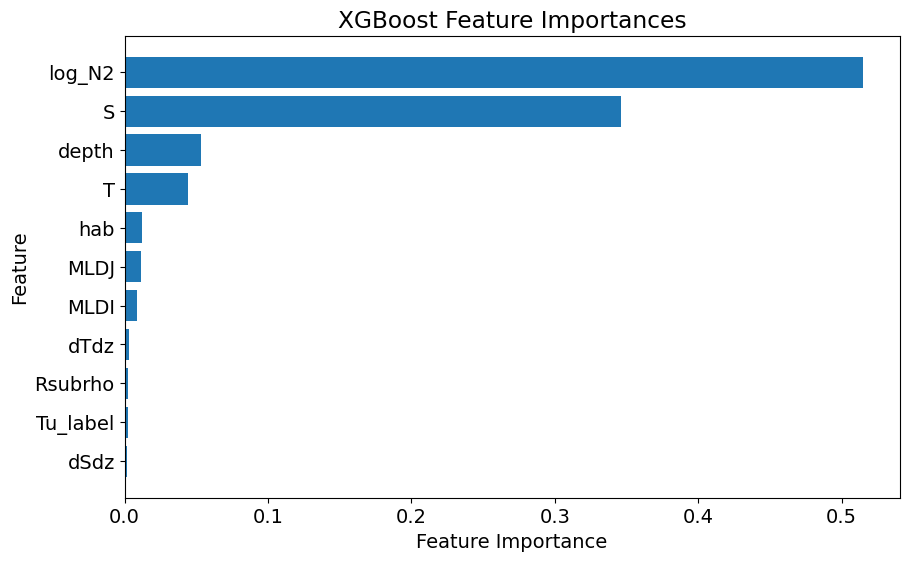

In [28]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho']

# We want to predict:
ystringlist_all = ['log_eps']

xgb_regressor_all, r2_all, y_test_all, y_pred_all, X_test_all, feature_importances_all = XGBoost_regressor(arctic_df, xstringlist_all , ystringlist_all)

In [29]:
print(r2_all) # 0.9688046904696355

0.9688046904696355


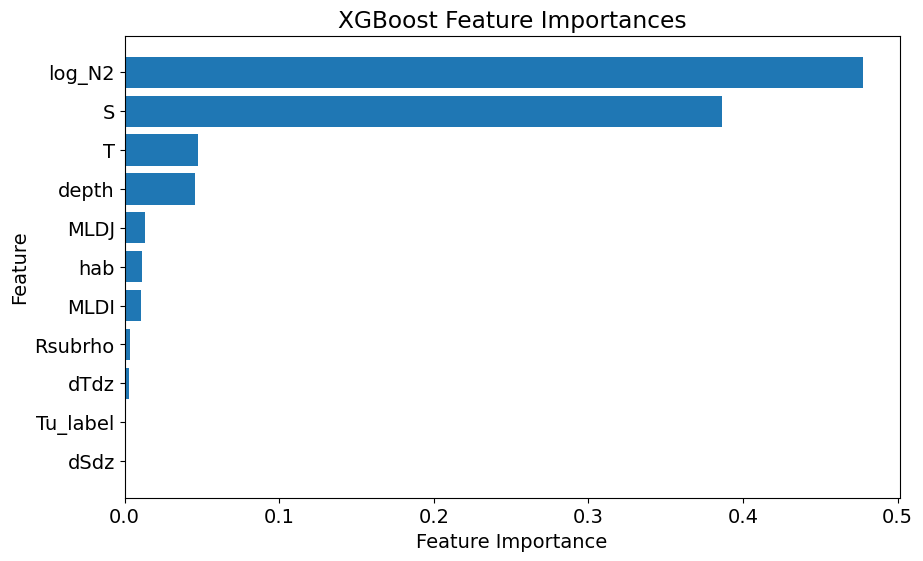

In [22]:
# Features:
# Ex MLD J
# excluded 'depth','hab', 
xstringlist_mld = ['depth','hab','S','T','latitude', 'dSdz','dTdz','log_N2', 'Tu_label', 'sea_ice_concentration', 'MLDJ', 'MLDI', 'Rsubrho']

# We want to predict:
ystringlist_mld = ['log_eps']

xgb_regressor_mld, r2_mld, y_test_mld, y_pred_mld, X_test_mld, feature_importances_mld = XGBoost_regressor(MLD_df, xstringlist_all , ystringlist_all)

In [24]:
print(r2_mld)

0.9716982360317057


In [30]:
# Reshape y_pred
y_pred_all = np.reshape(y_pred_all, (-1, 1))

X_test_df = pd.DataFrame(X_test_all, columns=xstringlist_all)
y_test_df = pd.DataFrame(y_test_all, columns=ystringlist_all)
y_pred_df = pd.DataFrame(y_pred_all, columns=['eps_pred'])

arctic_all_testdf = create_testdf(X_test_df, y_test_df, y_pred_df)
#plot_residuals(arctic_all_testdf)

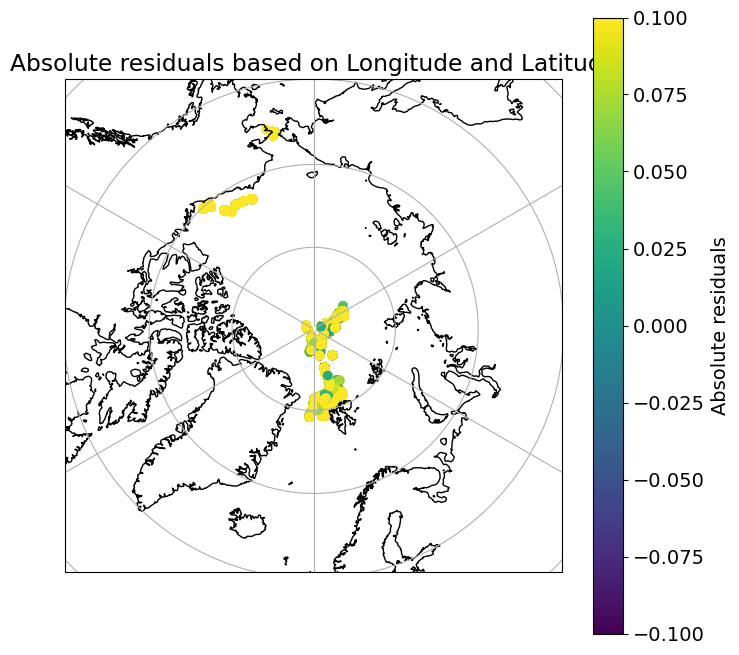

In [31]:
merged_df = arctic_all_testdf.merge(arctic_df, on=xstringlist_all+ystringlist_all)
merged_df = merged_df.drop_duplicates(subset=xstringlist_all+ystringlist_all)
residuals = (merged_df["log_eps"] - merged_df["eps_pred"])
stereo_plot(merged_df, residuals, "Absolute residuals")

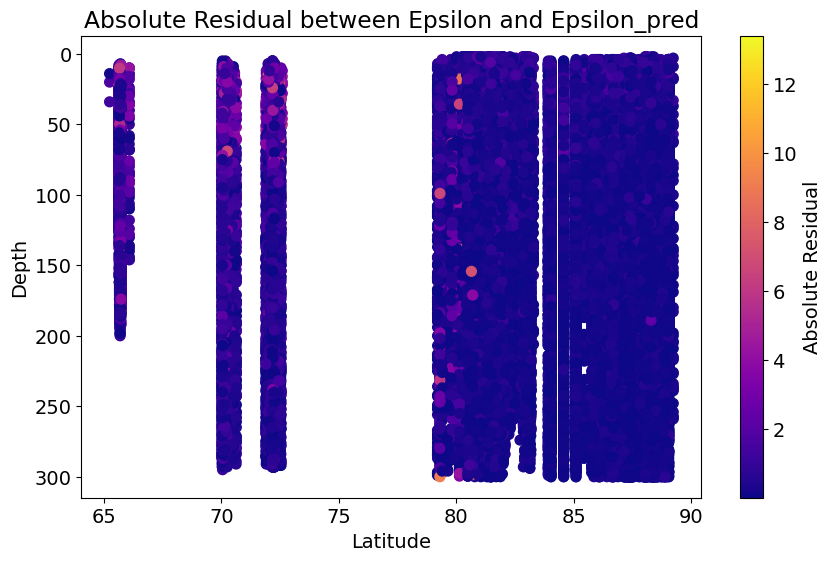

In [33]:
# arctic_all_testdf
plot_residuals(merged_df)

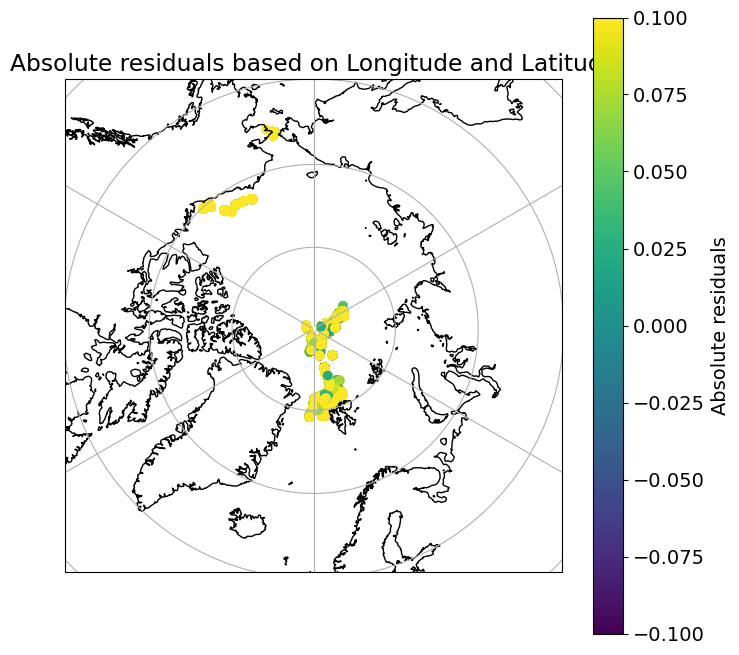

In [34]:
# Reshape y_pred
y_pred_mld = np.reshape(y_pred_all, (-1, 1))

X_test_mld = pd.DataFrame(X_test_mld, columns=xstringlist_all)
y_test_mld = pd.DataFrame(y_test_mld, columns=ystringlist_all)
y_pred_mld = pd.DataFrame(y_pred_mld, columns=['eps_pred'])

arctic_mld_testdf = create_testdf(X_test_mld, y_test_mld, y_pred_mld)
#plot_residuals(arctic_all_testdf)

merged_dfmld = arctic_mld_testdf.merge(MLD_df, on=xstringlist_all+ystringlist_all)
merged_dfmld = merged_df.drop_duplicates(subset=xstringlist_all+ystringlist_all)
residualsmld = (merged_dfmld["log_eps"] - merged_dfmld["eps_pred"])
stereo_plot(merged_dfmld, residualsmld, "Absolute residuals")

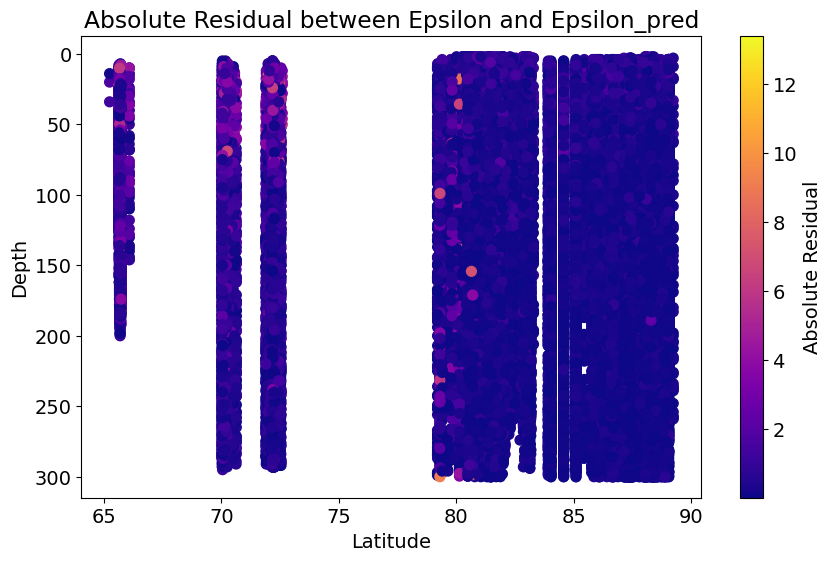

In [35]:
plot_residuals(merged_dfmld)

In [48]:
# on southern ocean
southern_df = global_df[global_df['latitude'] < -60]

X_test_S = southern_df[xstringlist_all]
y_test_S = southern_df[ystringlist_all]
y_pred_S = xgb_regressor_mld.predict(X_test_S)
r2 = r2_score(y_test_S, y_pred_S)
print(r2)

KeyError: "['Tu_label', 'sea_ice_concentration', 'MLDJ', 'MLDI', 'Rsubrho'] not in index"

## Test this on deep ocean data

In [29]:
X_test_new = arctic_df[(arctic_df['depth'] > 30) & (arctic_df['depth'] < 300)][xstringlist]
y_test_new = arctic_df[(arctic_df['depth'] > 30) & (arctic_df['depth'] < 300)][ystringlist]
y_pred_new = xgb_regressor1.predict(X_test_new)
r2 = r2_score(y_test_new, y_pred_new)
print(r2)

-2.954423338327577


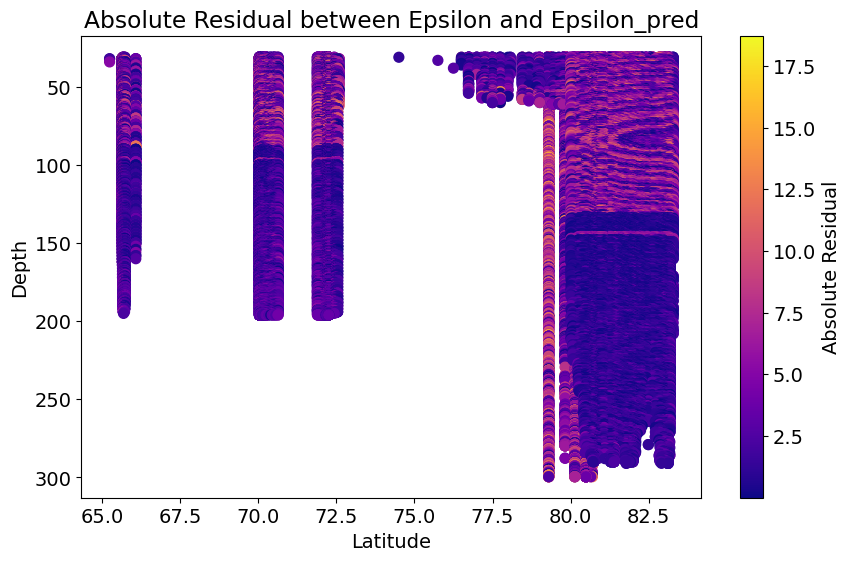

In [30]:
# Reshape y_pred
y_pred_new = np.reshape(y_pred_new, (-1, 1))
X_test_df2 = pd.DataFrame(X_test_new, columns=xstringlist)
y_test_df2 = pd.DataFrame(y_test_new, columns=ystringlist)
y_pred_df2 = pd.DataFrame(y_pred_new, columns=['eps_pred'])

arctic30m_testdf_new = create_testdf(X_test_df2, y_test_df2, y_pred_df2)
plot_residuals(arctic30m_testdf_new)

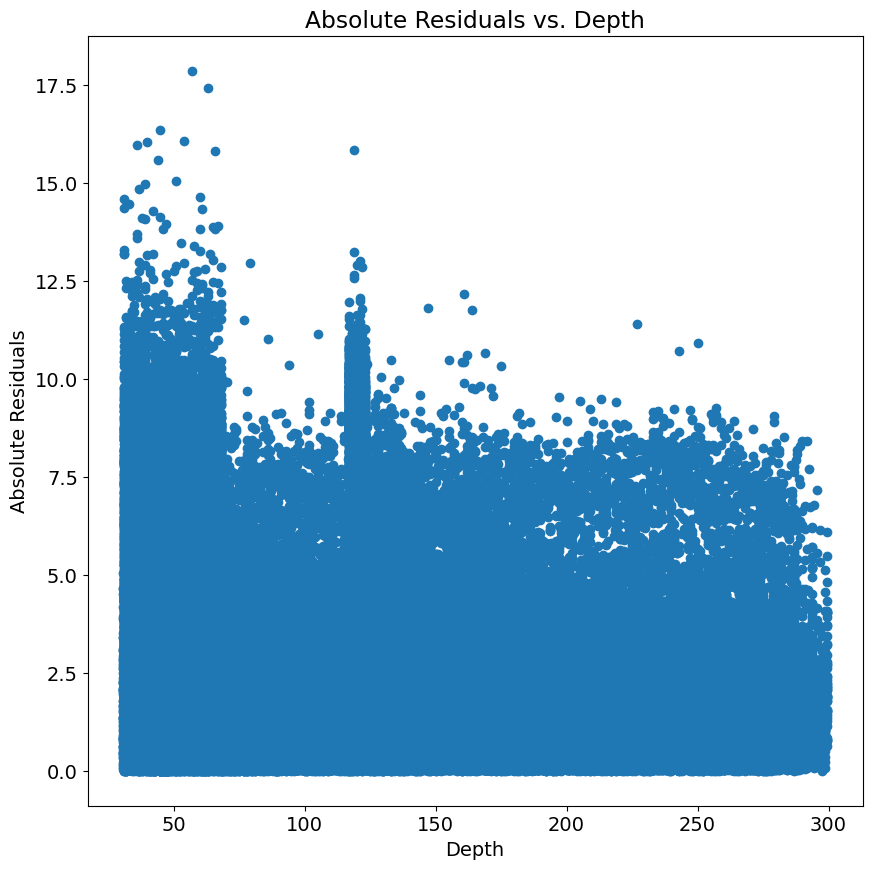

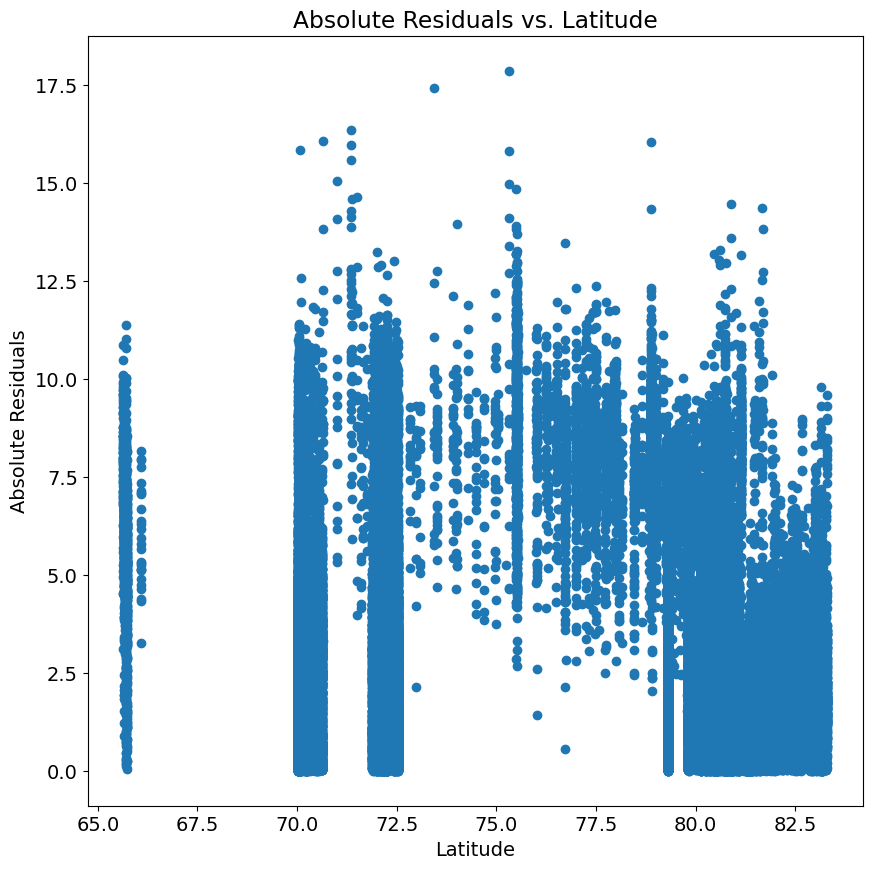

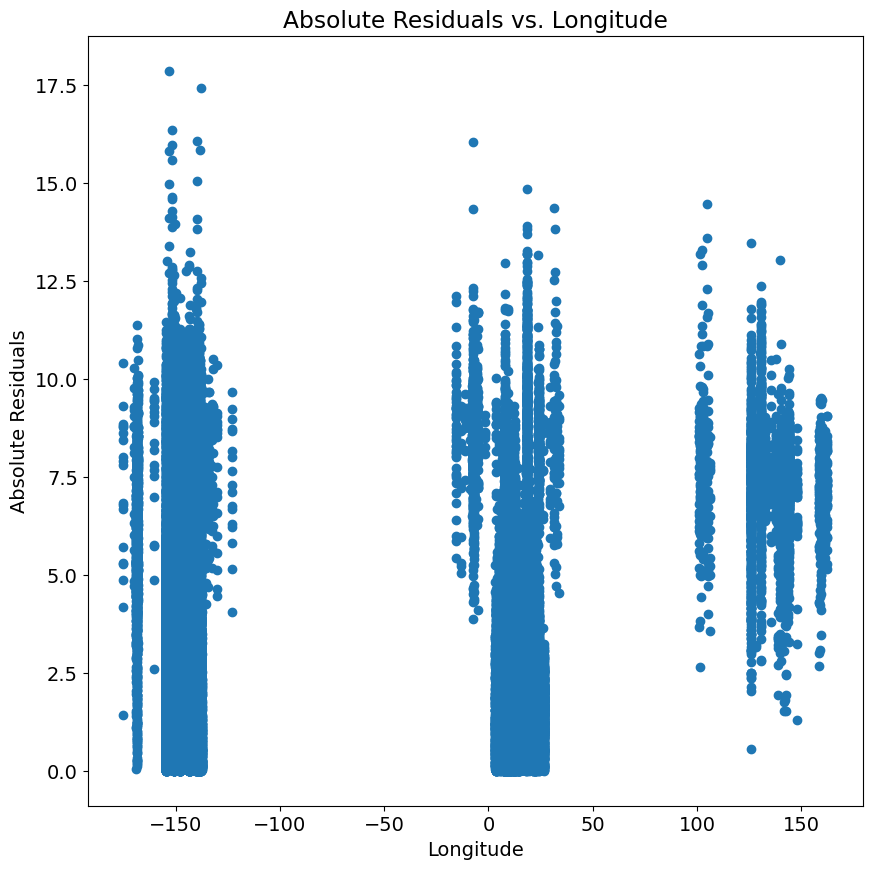

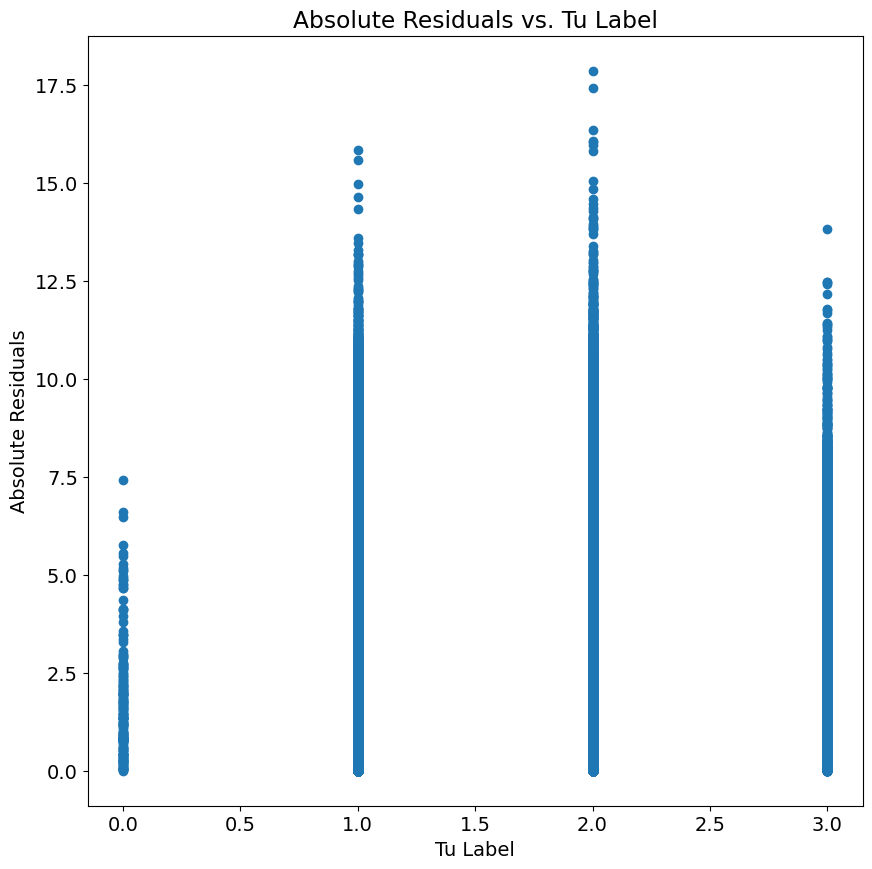

In [62]:
plot_correlations(arctic30m_mergeddf_new)

- depth: the absolute residuals tend to decrease. In other words, there is a weak negative linear relationship between depth and the absolute residuals.
- latitude: The correlation coefficient between latitude and absolute residuals is approximately -0.13. This negative correlation indicates that as latitude increases (moving towards higher latitudes), the absolute residuals tend to decrease. However, the correlation is relatively weak.
- Longitude: The correlation coefficient between longitude and absolute residuals is approximately -0.085. This negative correlation suggests that there is a very weak negative linear relationship between longitude and the absolute residuals. However, the correlation is quite weak, indicating that longitude may not have a strong influence on the absolute residuals.
- Tu Label: The correlation coefficient between tu_label and absolute residuals is approximately 0.031. This positive correlation indicates a weak positive linear relationship between tu_label and the absolute residuals. However, the correlation is quite weak, suggesting that tu_label may not have a strong influence on the absolute residuals.

# See if we can predict southern ocean with this model.

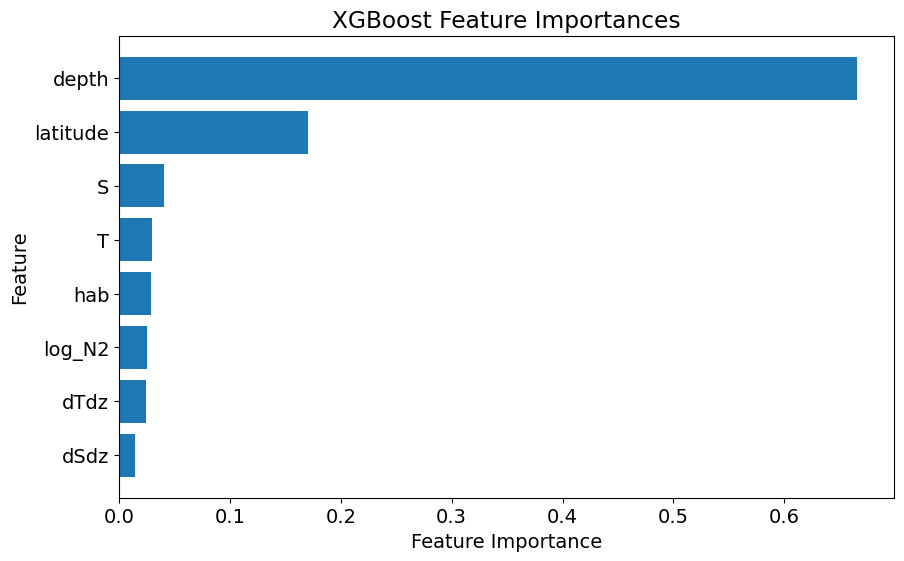

In [57]:
# Features:
xstringlist3 = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2']

# We want to predict:
ystringlist3 = ['log_eps']

xgb_regressor3, r2, y_test, y_pred, X_test, feature_importances = XGBoost_regressor(arctic_df, xstringlist3, ystringlist3)

In [58]:
southern_df = global_df[global_df['latitude'] < -60]

X_test_S = southern_df[xstringlist3]
y_test_S = southern_df[ystringlist3]
y_pred_S = xgb_regressor3.predict(X_test_S)
r2 = r2_score(y_test_S, y_pred_S)
print(r2)

-303.2643757220732


## Do global model as well

In [ ]:
# Features:
xstringlist_g = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2']

# We want to predict:
ystringlist_g = ['log_eps']

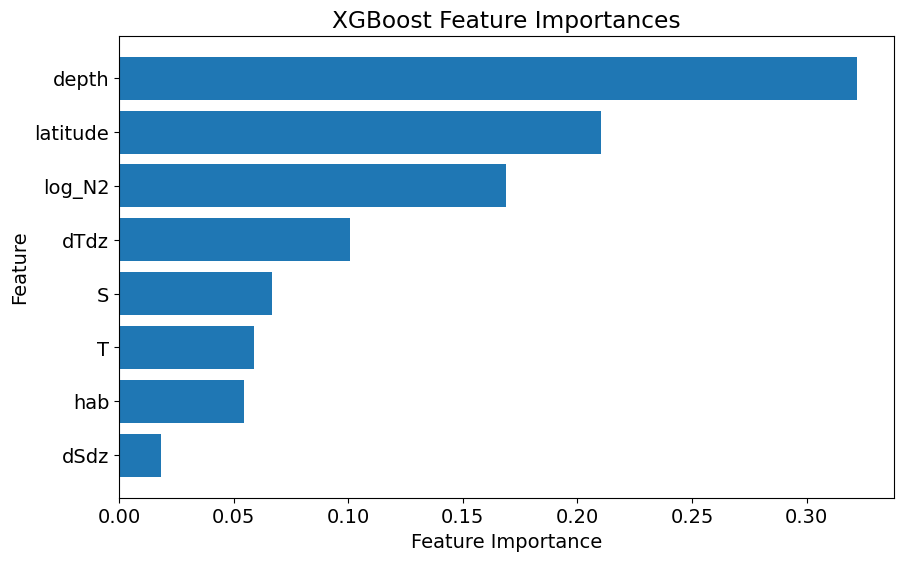

In [28]:
global_xgb_regressor, global_r2, global_y_test, global_y_pred, global_X_test, global_feature_importances = XGBoost_regressor(global_df, xstringlist , ystringlist)

In [29]:
print(global_r2)

0.6339672666621631


In [ ]:
best_model_g, r2_tune_g, y_test_tune_g, y_pred_tune_g, X_test_tune_g, feature_importances_tune_g = XGBoost_regressor_tuning(global_df, xstringlist_g, ystringlist_g)

In [ ]:
print(r2_tune_g)

In [ ]:
# Save the best_model
with open('models/best_model_global_xbg.pickle', 'wb') as file:
    pickle.dump(best_model_g, file)
    
best_model_params_g = best_model.get_params()
print(best_model_params_g)

### use this model to predict epsilon for arctic_df

In [ ]:
# Features:
xstringlist = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'latitude']

# We want to predict:
ystringlist = ['log_eps']

In [30]:
# Make predictions on arctic_df using global_xgb_regressor
arctic_X_test = arctic_df[xstringlist].values
arctic_y_pred = global_xgb_regressor.predict(arctic_X_test)

# Evaluate the predictions on arctic_df using global_y_test
arctic_y_test = arctic_df[ystringlist].values
arctic_r2 = r2_score(arctic_y_test, arctic_y_pred)

# Get feature importances for arctic_df
arctic_feature_importances = global_xgb_regressor.feature_importances_

In [31]:
print("Using global XGboost model on arctic data", arctic_r2)

-25.789339171054312